In [144]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array
import statsmodels.api as sm
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

dfs = pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + ['data/'+name] for name in os.listdir('data') if name[0] != '.')
dfs = dfs.rename(columns={0:'source_id', 1:'experiment_id',2:'member_id',3:'variable_id',4:'file_name'})
dfs.to_csv('saved-data.csv')
dfs = pd.read_csv('saved-data.csv')


In [ ]:
def tcr_classic(ts_expt, ts_ctrl):
    m_expt = np.mean(ts_expt[60*12:80*12])
    m_ctrl = np.mean(ts_expt[0:20*12])
#     m_ctrl = np.mean(ts_ctrl[60*12:80*12])
    std_expt = np.std(np.random.choice(ts_expt[60*12:80*12], 10000)) / np.sqrt(240)
    std_ctrl = np.std(np.random.choice(ts_expt[0:20*12], 10000)) / np.sqrt(240)
    return m_expt - m_ctrl, np.sqrt(np.sum(np.square([std_expt,std_ctrl])))

In [ ]:
#return dates for all datasets with real date values
def real_dates(ds):
    return [d for d in [pd.to_datetime(n, errors='coerce') for n in ds] if str(d[0]) != 'NaT']

In [ ]:
def linear(x, a, b):
    return a*x + b

def ecs_gregory(ts, Ns, window=12):
    tavgs = []
    Navgs = []
    nwindows = int(len(ts)/window)
    for n in range(nwindows-2):
        tavgs += [np.mean(ts[n+1*window:(n+2)*window])]
        Navgs += [np.mean(Ns[n+1*window:(n+2)*window])]
        
    popt, pcov = curve_fit(linear, tavgs, Navgs)
    
    return popt, pcov, - popt[1] / (2 * popt[0]), [tavgs, Navgs]
    

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

In [ ]:
def find(**keys):
    ndfs = dfs.copy()
    for k,v in keys.items():
        ndfs = ndfs[ndfs[k] == v]
    return ndfs

In [169]:
def load(ndfs=None, **keys):
    if isinstance(ndfs, type(None)):
        ndfs = find(**keys)
    ns = dict([(f, np.load(f, allow_pickle = True)) for f in ndfs.file_name])
    return ns

# make a list of all transcribable dates
ts = load(dfs).items()
dates = [d for d in [pd.to_datetime(n[1][1], errors='coerce') for n in ts] if str(d[0]) != 'NaT']

In [170]:
def plot_time_var(window, fmt, delta=False, avg_variants=False, data=None, **keys):
    # Get search results of right length
    ts = load(**keys).items()
    ts = np.array([t for t in ts if len(t[1][0]) > window])
    if len(ts) == 0:
        print("No data fit these keys")
        return
    
    # Plot each dataset in the same figure
    for f, v in sorted(ts, key=lambda x: x[0]):
        w = window
        var = moving_average(v[0] - int(delta) * np.mean(v[0,0:min(window, 12)]), w)
        d = next((d for d in dates if len(d) == len(v[0])),None)
        if not isinstance(d, type(None)):
            plt.plot_date(d[int(w/2)-1:int(len(v[0])-w/2)], var, xdate=True, fmt=fmt, label=f)

In [171]:
def ensemble_mean(expt, var):
    means = {}
    results = find(experiment_id=expt, variable_id=var).groupby('source_id')
    for source, group in results:
        data = load(group)
        xs = [d[0] for d in data.values()]
        ts = [d[1] for d in data.values()]
        mean = np.average(np.array([x for x in xs if len(x) == max([len(x) for x in xs])]),0)
        means[source] = mean
    return means

Plot a moving average for the ensemble
=======

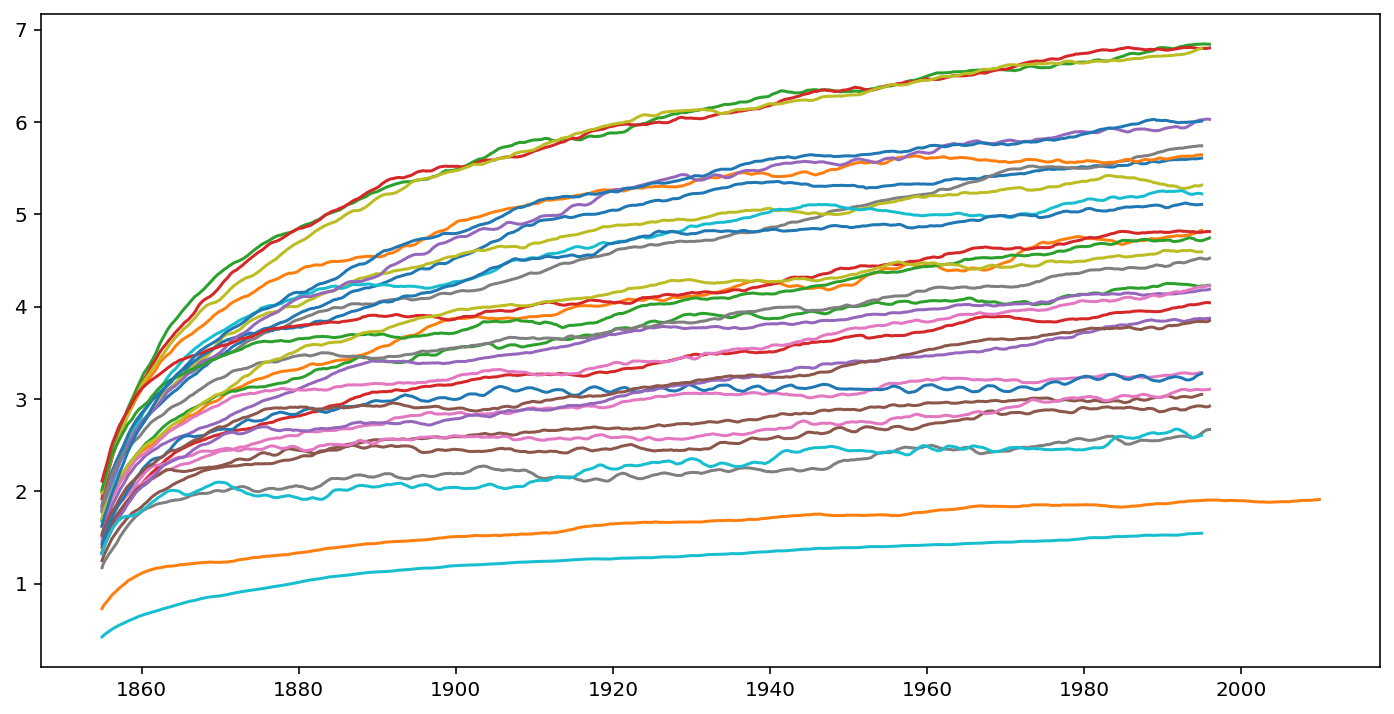

In [30]:
plt.figure('1pctCO2 runs')
plot_time_var(window=10*12, fmt='-', delta=True, experiment_id ='abrupt-4xCO2', variable_id='ts')

Get all TCRs using $\Delta T$ at $2 \times CO_2$
=========

In [ ]:
tcrs = []
mlds = []
names = []
var = 'tos'

expt_mlds = pd.read_csv('average_mlds.csv')
expt_mlds = expt_mlds[(expt_mlds.experiment_id == '1pctCO2') & (expt_mlds.months > 120)]
ed = dict(list(zip(expt_mlds.source_id.values, expt_mlds['mean'].values)))

ts = ensemble_mean('1pctCO2',var)
pi_ts = ensemble_mean('piControl',var)
avg_mlds = ensemble_mean('1pctCO2','mlotst')
avg_mlds.update(ed)
for k in ts.keys() & pi_ts.keys() & pi_mlds.keys():
    pi_t = pi_ts[k]
    t = ts[k]
    
    tcr, err = tcr_classic(t, pi_t)
    
    mld = np.mean(avg_mlds[k])
    mlds += [mld]
    tcrs += [[tcr, err]]
    names += [k]
    

tcrs = np.array(tcrs)
mlds = np.array(mlds)

vals = zip(mlds, tcrs)
vals = [v for v in vals if v[0] > 26 and v[1][0] > 0]
mlds = np.array(vals)[:,0]
tcrs = np.array([v[1] for v in vals])
srtd = np.array(sorted(tcrs, key = lambda x: x[0]))


plt.errorbar(x=list(range(len(tcrs))), y=srtd[:,0], yerr=srtd[:,1], fmt='o', capsize=4)
plt.figure()
plt.errorbar(x=1/mlds, y=tcrs[:,0], yerr=tcrs[:,1], fmt='ok', capsize=4)
popt, pcov = curve_fit(linear, 1/mlds, tcrs[:,0])
plt.plot(np.linspace(0.01, 0.05), linear(np.linspace(0.01, 0.05),*popt))
plt.xlabel("1/MLD,  m$^{-1}$")
plt.ylabel("TCR ["+var+"],  K")

Compare ECS to average PiControl MLD
======

Text(0, 0.5, 'ECS [tos],  K')

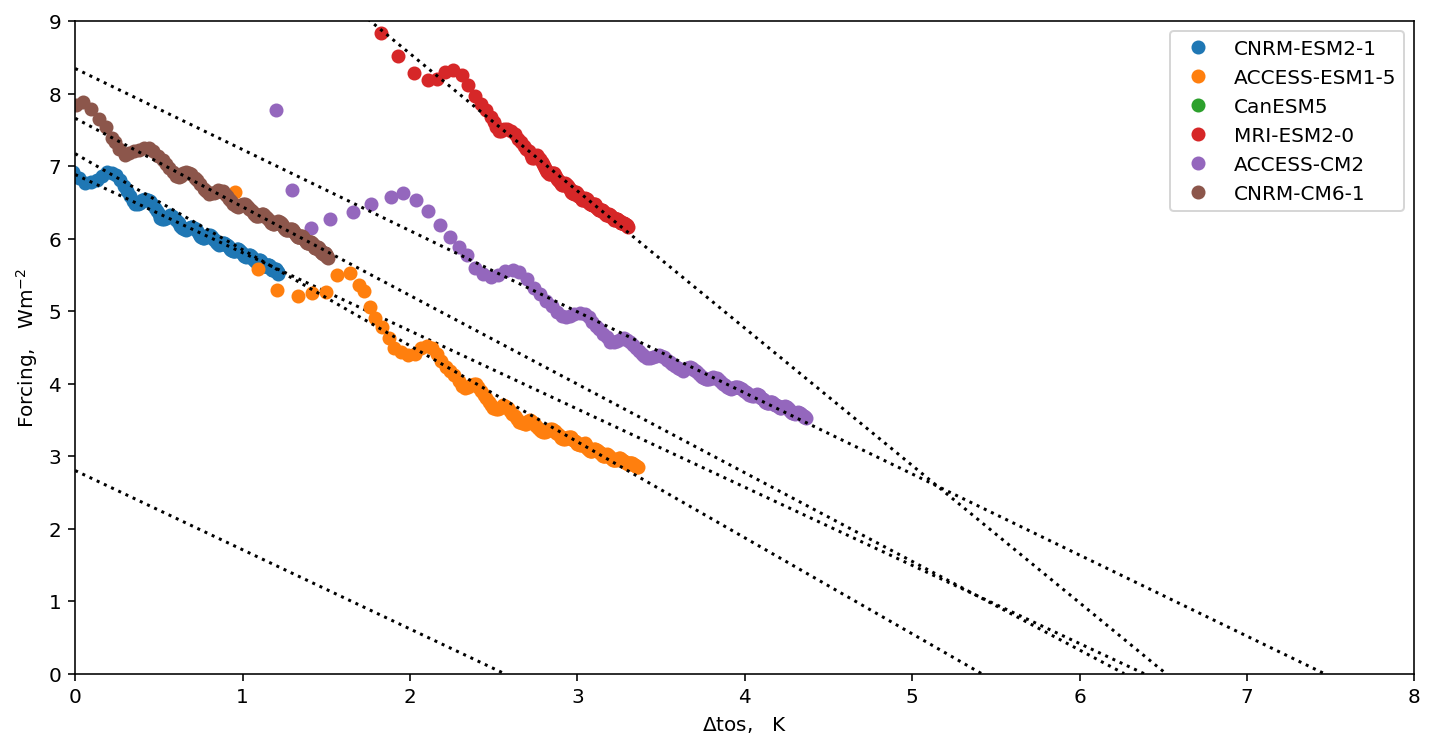

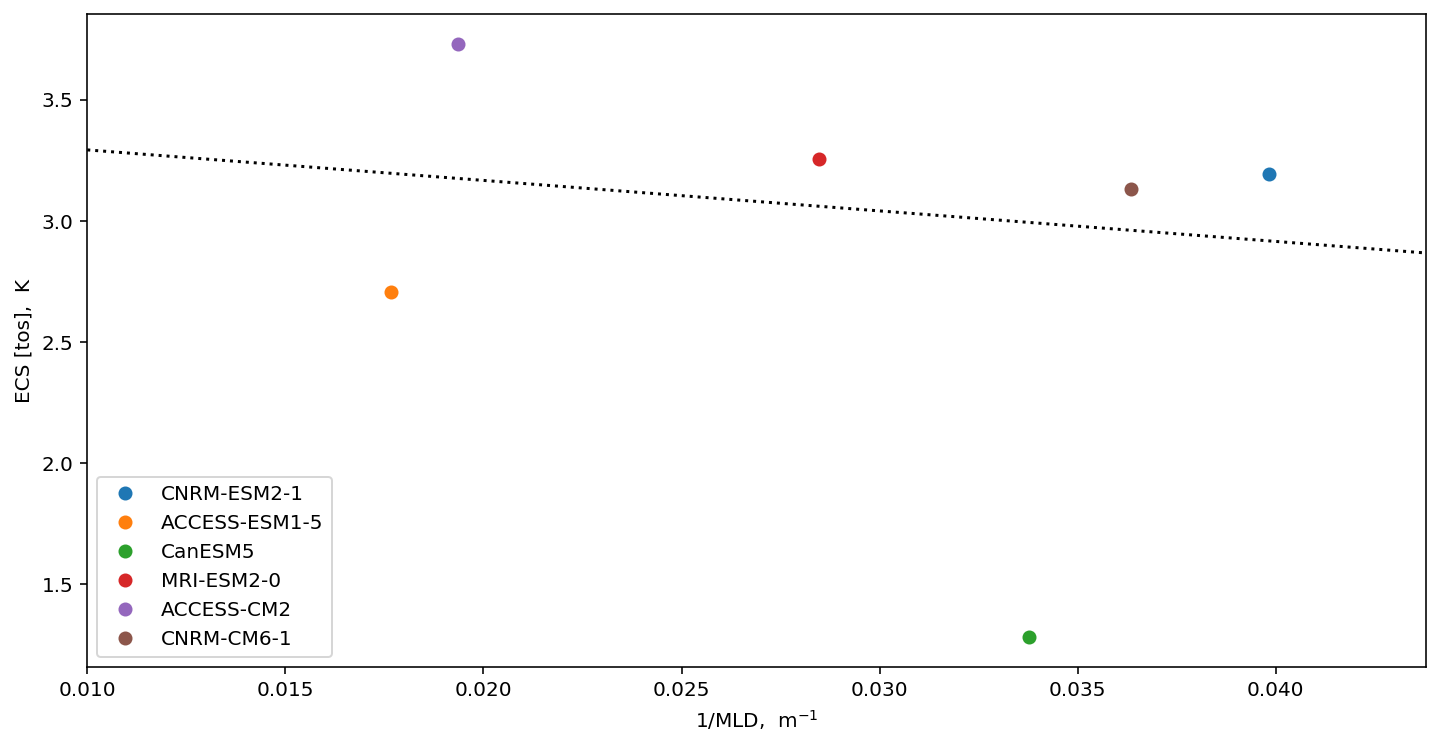

In [158]:
ecss = []
mlds = []
rtmts = []
data = []
var = 'tos'
pi_ts = ensemble_mean('piControl', var)
pi_mlds = ensemble_mean('abrupt-4xCO2', 'mlotst')

expt_mlds = pd.read_csv('average_mlds.csv')
expt_mlds = expt_mlds[(expt_mlds.experiment_id == 'abrupt-4xCO2') & (expt_mlds.months > 120)]
ed = dict(list(zip(expt_mlds.source_id.values, expt_mlds['mean'].values)))
pi_mlds.update(ed)

ts = ensemble_mean('abrupt-4xCO2', var)
Rs = ensemble_mean('abrupt-4xCO2', 'hfds')
for k in pi_ts.keys() & pi_mlds.keys() & ts.keys() & Rs.keys():
    
    t = ts[k]
    pi_t = pi_ts[k]
    R = Rs[k]
    mld = np.mean(pi_mlds[k])
    
    if len(t) < 100*12 or len(R) != len(t) or np.mean(R) < 0:
        continue
    
    minlen = min(len(t),len(pi_t))
    popt, pcov, ecs, toplot = ecs_gregory(t[0:minlen] - pi_t[0:minlen], R[0:minlen])
    
    if ecs < 0:
        continue
    
    ecss += [ecs]
    rtmts += [np.mean(R[0:60])]
    mlds += [mld]
    
    data += [[k, ecs, mld]]
    
#     plt.figure('mld')
#     plt.plot(moving_average(pi_mlds[k], 10*12))
    plt.figure('ECS')
    plt.plot(toplot[0], toplot[1], 'o', label=k)
    plt.plot(np.linspace(0,2*ecs), linear(np.linspace(0, 2*ecs),*popt), ':k')
    
    plt.figure('MLDS')
    plt.plot(1/mld, ecs, 'o', label=k)
    
    
plt.figure('ECS')
plt.legend()
plt.xlim([0,8])
plt.ylim([0,9])
plt.xlabel("$\Delta$"+var+",   K")
plt.ylabel("Forcing,   Wm$^{-2}$")
# df = pd.DataFrame(data)
# df.to_csv('abrupt-4x_'+var+'_ranks.csv')

mlds = np.array(mlds)

plt.figure('MLDS')
plt.legend()
popt, pcov = curve_fit(linear, 1/mlds, ecss)
plt.plot(np.linspace(0.01, 1.1*max(1/mlds)), linear(np.linspace(0.01, 0.03),*popt), ":k")
plt.xlim([0.01, 1.1*max(1/mlds)])
plt.xlabel("1/MLD,  m$^{-1}$")
plt.ylabel("ECS ["+var+"],  K")

Save data to compare MLDs by models
====

In [ ]:
ab = ensemble_mean('abrupt-4xCO2', 'mlotst')
ppy = ensemble_mean('1pctCO2', 'mlotst')
pi = ensemble_mean('piControl','mlotst')
data = []
for k in ab.keys() & ppy.keys() & pi.keys():
    data += [[k, np.mean(pi[k]), np.mean(ppy[k]), np.mean(ab[k])]]
pd.DataFrame(data).to_csv('mlotst-compare.csv')

Plot TCRs against ECSs
=====

In [ ]:
var = 'tos'
pi_ts = ensemble_mean('piControl', var)
p_ts = ensemble_mean('1pctCO2', var)
a_ts = ensemble_mean('abrupt-4xCO2', var)
Rs = ensemble_mean('abrupt-4xCO2', 'hfds')

ecss = []
tcrs = []
names = []
for k in pi_ts.keys() & p_ts.keys() & Rs.keys():
    pi_t = pi_ts[k]
    p_t = p_ts[k]
    
    tcr, err = tcr_classic(p_t, pi_t)
    
    a_t = a_ts[k]
    R = Rs[k]
    
    if len(a_t) < 700 or len(R) != len(a_t) or np.mean(R) < 0:
        print('failed on ',k)
        print(len(R))
        print(len(a_t))
        print(np.mean(R))
        continue
    
    minlen = min(len(a_t),len(pi_t))
    popt, pcov, ecs, toplot = ecs_gregory(a_t[0:minlen] - pi_t[0:minlen], R[0:minlen])
    
    if ecs < 0:
        continue
    
    ecss += [ecs]
    tcrs += [[tcr, err]]
    names += [k]
    
    plt.errorbar(ecs, y=tcr, yerr=err, fmt='o', capsize=4, label=k)
    
tcrs = np.array(tcrs)
ecss = np.array(ecss)
plt.ylabel("TCR ["+var+"]")
plt.xlabel("ECS ["+var+"]")
plt.legend()

Make spreadsheet of average mixed layer depths
======

In [ ]:
da = pd.DataFrame()
ppt = ensemble_mean('1pctCO2', 'mlotst')
ab = ensemble_mean('abrupt-4xCO2', 'mlotst')
pi = ensemble_mean('piControl', 'mlotst')
da = pd.DataFrame([(i[0], np.mean(i[1])) for i in ppt.items()]).rename(columns={0:'source_id',1:'average_mld_1pct'})
da = da.merge(pd.DataFrame([(i[0], np.mean(i[1])) for i in ab.items()]).rename(columns={0:'source_id',1:'average_mld_abrpt'}), how='outer', on='source_id')
da = da.merge(pd.DataFrame([(i[0], np.mean(i[1])) for i in pi.items()]).rename(columns={0:'source_id',1:'average_mld_pi'}), how='outer', on='source_id')
da.to_csv('MLD-Rankings.csv')

Test tos against ts for different models
======

AWI-CM-1-1-MR
GISS-E2-1-G
MPI-ESM1-2-HR


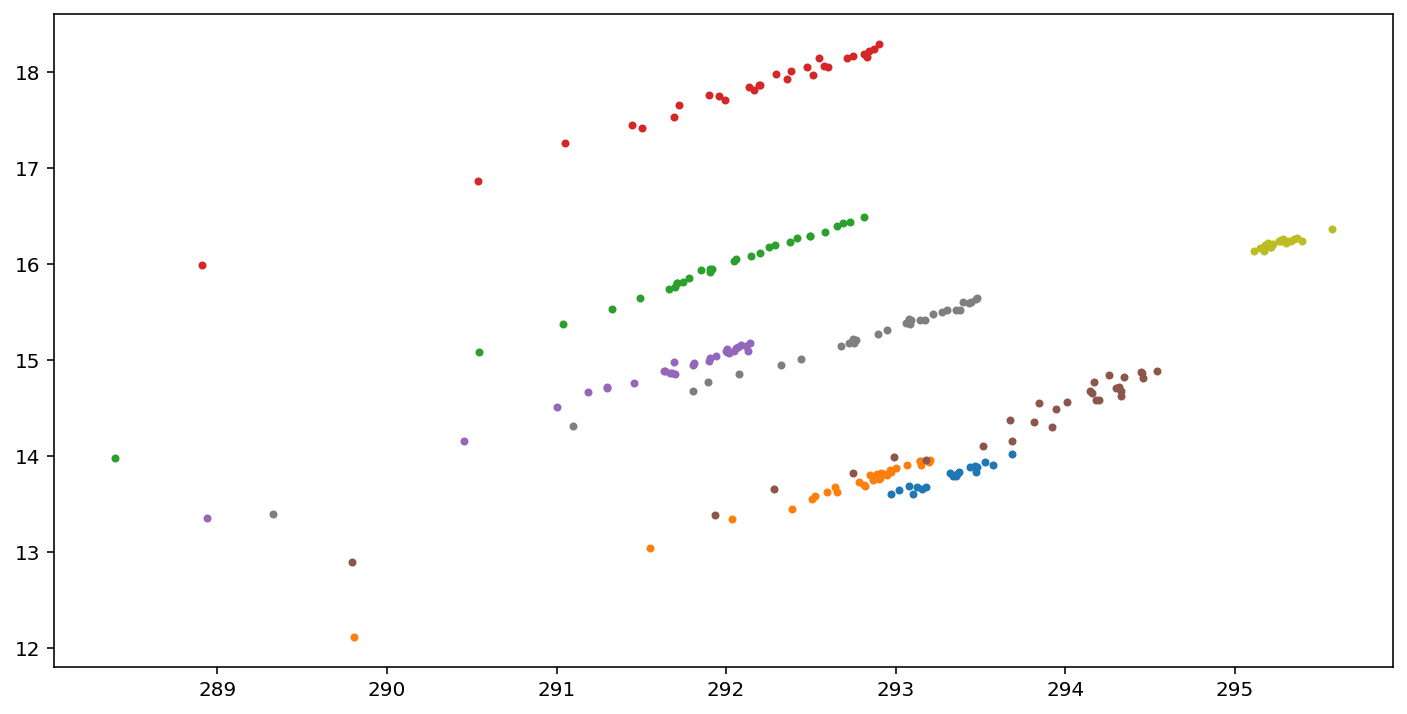

In [25]:
expt = "abrupt-4xCO2"
ts = ensemble_mean(expt,'ts')
tos = ensemble_mean(expt,'tos')
tspi = ensemble_mean("piControl",'ts')
tospi = ensemble_mean("piControl",'tos')
for k in ts.keys() & tos.keys():
    m = min([len(ts[k]),len(tos[k])]) - 1
    x = moving_average(ts[k][0:m], 10)
    y = moving_average(tos[k][0:m], 10)
    xi = [x[60*i] for i in range(0,int(len(x)/60))]
    yi = [y[60*i] for i in range(0,int(len(y)/60))]
#     tcr1, err1 = tcr_classic(ts[k], pi_t)
    if x[0] < 200 or y[0] < 10: 
        print(k)
        continue
    x = sm.add_constant(list(x))
    model = sm.OLS(list(y),x)
    results = model.fit()
    if(results.rsquared < 0.9):
        plt.plot(xi,yi,'.',label=k)


In [28]:
hfds = dfs[(dfs.variable_id == "hfds") & (dfs.experiment_id == "abrupt-4xCO2")]
for k, g in hfds.groupby(['source_id']):
    print(k, str(len(g)))

ACCESS-CM2 1
ACCESS-ESM1-5 1
CNRM-CM6-1 1
CNRM-CM6-1-HR 1
CNRM-ESM2-1 3
CanESM5 2
FGOALS-f3-L 2
IPSL-CM6A-LR 1
MCM-UA-1-0 1
MRI-ESM2-0 6


[0.9637698508048166]
data/UKESM1-0-LL_abrupt-4xCO2_r1i1p1f2_ts.npy


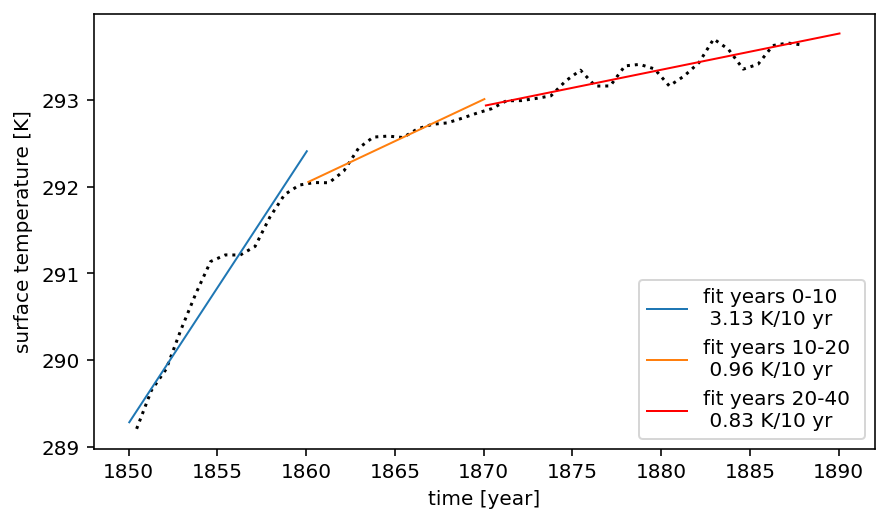

In [140]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 4

import matplotlib.dates as mdates
ab = load(experiment_id = 'abrupt-4xCO2', variable_id = 'ts')
name, vals = list(ab.items())[9]


w = 12
v, d = vals
v = v[0:480]
var = moving_average(v, w)
dv = d[int(w/2)-1:int(len(v)-w/2)]
var = [var[i*10] for i in range(int((len(var)-1)/10))]
dv = [dv[i*10] for i in range(int((len(dv)-1)/10))]
plt.plot_date(dv, var, xdate=True,fmt=':k')

popt,pcov = curve_fit(linear,xdata=mdates.date2num(d[0:120]),ydata=v[0:120])
lx = np.linspace(*mdates.date2num([d[0],d[120]]))
slope = popt[0] * (mdates.date2num(d[120]) - mdates.date2num(d[0]))
plt.plot_date(mdates.num2date(lx),linear(lx, *popt),xdate=True,
              fmt='-',
              linewidth=1,
              label="fit years 0-10 \n %.2f K/10 yr"% slope)

popt,pcov = curve_fit(linear,xdata=mdates.date2num(d[121:240]),ydata=v[121:240])
lx = np.linspace(*mdates.date2num([d[121],d[240]]))
slope = popt[0] * (mdates.date2num(d[120]) - mdates.date2num(d[0]))
plt.plot_date(mdates.num2date(lx),linear(lx, *popt),xdate=True,
              fmt='-',
              linewidth=1,
              label="fit years 10-20 \n %.2f K/10 yr"% slope)

popt,pcov = curve_fit(linear,xdata=mdates.date2num(d[241:480]),ydata=v[241:480])
lx = np.linspace(*mdates.date2num([d[241],d[480]]))
slope = popt[0] * (mdates.date2num(d[240]) - mdates.date2num(d[0]))
plt.plot_date(mdates.num2date(lx),linear(lx, *popt),xdate=True,
              fmt='-',
              color='red',
              linewidth=1,
              label="fit years 20-40 \n %.2f K/10 yr"% slope)

print(dts)
print(name)

plt.xlabel("time [year]")
plt.ylabel("surface temperature [K]")
plt.legend()

In [ ]:
dict(list(dfs.groupby(['source_id','experiment_id'])))

Generate image of all time series data for a given variable
=====

No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys
No data fit these keys


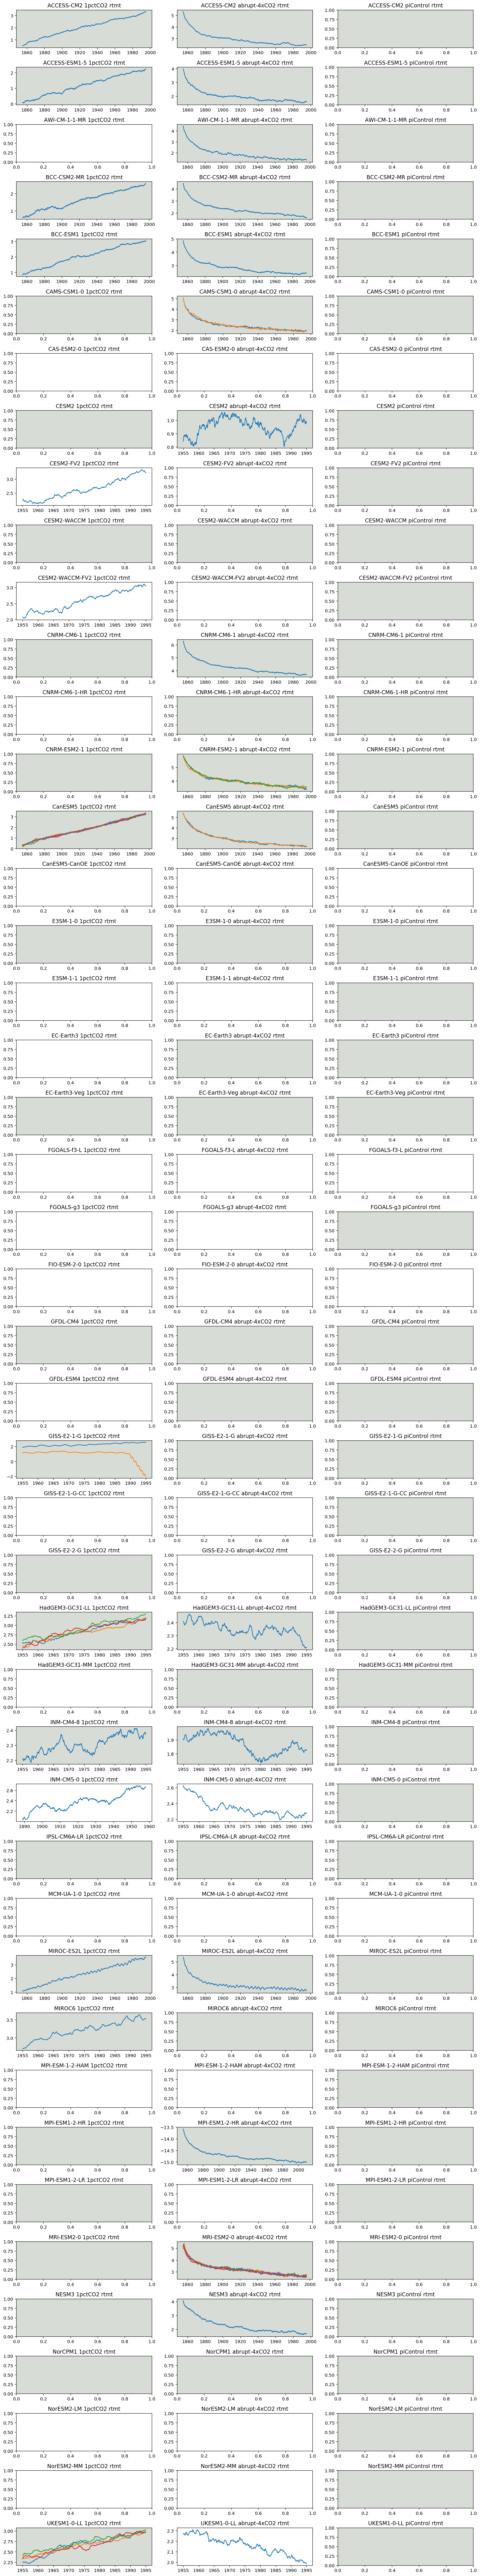

In [186]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 80
%config InlineBackend.figure_format = 'retina'

var = 'rtmt'
pg = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') # to mark pangeo data
N = len(set(dfs.source_id.values)) # number of sources
bysrc = list(dfs.groupby('source_id')) # grouped alphabetically by source
exps = ['1pctCO2', 'abrupt-4xCO2', 'piControl'] # experiments in each column
nrows = N
ncols = 3
# for var in ['tos','rtmt','hfds','mlotst','tas']:
plt.figure("all-plots-"+var, constrained_layout=False)
for i in range(N):
    src, grp = bysrc[i]
    grp = grp[grp.variable_id == var]
    for j in range(3):
        exp = exps[j]
        subgrp = grp[(grp.experiment_id == exp) & (grp.variable_id == var)]
        ax = plt.subplot(nrows, ncols, (3*i)+j+1)
        if len(subgrp) > 0:
            plot_time_var(window=10*12, fmt='-', delta=False, experiment_id =exp, variable_id=var, source_id = src) 
        plt.title(src+' '+exp+' '+var)
        plt.tight_layout()
        if len(pg[(pg.variable_id == var) & (pg.source_id == src) & (pg.experiment_id == exp)]) > 0:
            ax.set_facecolor('#d8dcd6')
        else:
            prg = pg[(pg.source_id == src) & (pg.experiment_id == exp)]
            if len(prg[prg.variable_id == 'rsdt']) > 0 and len(prg[prg.variable_id == 'rlut']) > 0 and len(prg[prg.variable_id == 'rsut']) > 0:
                ax.set_facecolor('#d8dcd6')
plt.savefig("all_"+var+".png")

In [190]:
td = pd.DataFrame()
pg = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') # to mark pangeo data
N = len(set(dfs.source_id.values)) # number of sources
bysrc = list(dfs.groupby('source_id')) # grouped alphabetically by source
exps = ['1pctCO2', 'abrupt-4xCO2', 'piControl'] # experiments in each column
nrows = N
ncols = 3
for var in ['tos','rtmt','hfds','mlotst','tas']:
    for i in range(N):
        src, grp = bysrc[i]
        grp = grp[grp.variable_id == var]
        for j in range(3):
            exp = exps[j]
            subgrp = grp[(grp.experiment_id == exp) & (grp.variable_id == var)]
            if len(subgrp) == 0:
                prg = prg = pg[(pg.source_id == src) & (pg.experiment_id == exp)]
                if len(prg[(prg.variable_id == var)]) > 0:
                    td = pd.concat([td, prg[(prg.variable_id == var)]])
                elif var == 'rtmt':
                    if len(prg[prg.variable_id == 'rsdt']) > 0 and len(prg[prg.variable_id == 'rlut']) > 0 and len(prg[prg.variable_id == 'rsut']) > 0:
                        td = pd.concat([td, 
                                        prg[prg.variable_id == 'rsdt'],
                                        prg[prg.variable_id == 'rlut'],
                                        prg[prg.variable_id == 'rsut']
                                       ])

In [192]:
td.to_csv('pangeo-retry.csv')